#### Libraries importeren

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

#### Set seed

In [2]:
np.random.seed(42)
torch.manual_seed(42)

#### Dataset inladen en inzien
Voordat ik de data volledig ga transformeren, wil ik eerst het gemiddelde en de standaardafwijking weten voor de normalisatie. Daarnaast wil ik ook weten wat de grote van de afbeelding is qua pixels en het kanaal (grijstinten of rgb).

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

alle_afbeeldingen = torch.cat([image.unsqueeze(0) 
                               for image, _ in train_data], dim=0)

print(f"Gemiddelde: {alle_afbeeldingen.mean().item():.4f}, Standaardafwijking: {alle_afbeeldingen.std().item():.4f}")

Gemiddelde: 0.1307, Standaardafwijking: 0.3081


In [4]:
image, label = train_data[7]
print(f"Afbeelding formaat: {image.shape}")

Afbeelding formaat: torch.Size([1, 28, 28])


#### Data transformeren

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)), #Juiste afmetingen invoeren 
    transforms.RandomRotation(10),  #Willekeurige rotaties tot 10 graden
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10), #Willekeurige onregelmatigheden 
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.05), ratio=(0.3, 3.3)),
    transforms.Normalize((0.1307,), (0.3081,)) #Normalisatie op basis van het gem en standaardafwijking
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Train data inspecteren

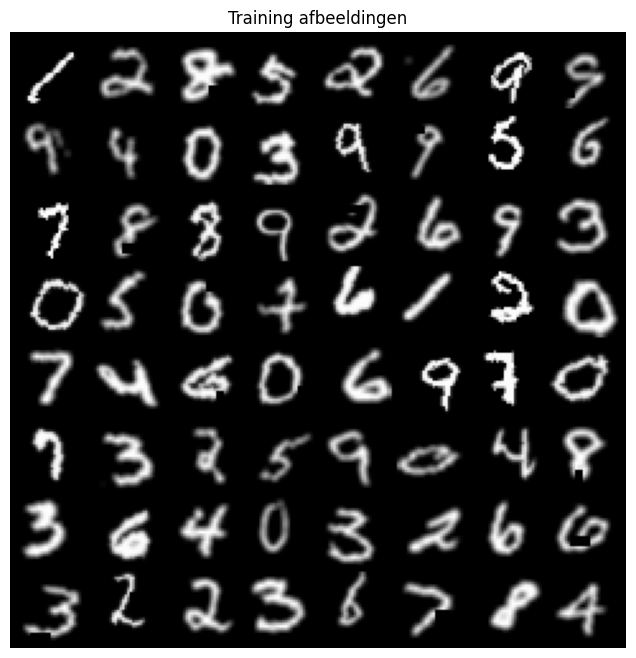

In [6]:
eerste_batch = next(iter(train_loader))
images, labels = eerste_batch

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training afbeeldingen")

grid_afbeeldingen = np.transpose(vutils.make_grid(images[:64], padding=2, normalize=True), (1, 2, 0))

plt.imshow(grid_afbeeldingen)
plt.show()

#### Architectuur van CNN bouwen

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(256, 10)
)

#### Check voor GPU
I.v.m. dat het model zwaar kan zijn, check ik eerst ff of het huidige apparaat een GPU heeft. Dit kan het trainen een stuk versneller namelijk.

In [8]:
component = torch.device("cuda" if torch.cuda.is_available()
                         else "cpu")
model = model.to(component)
print(f"Model runt op {component}")

Model runt op cpu


#### Model trainen

In [9]:
optimalisator = optim.Adam(model.parameters(), lr=0.0001)
criterium = nn.CrossEntropyLoss()

In [76]:
epochs = 10
for epoch in range(epochs):
    model.train()
    totale_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(component), labels.to(component) #Runt het model op geschikte component
        
        optimalisator.zero_grad()
        output = model(images)
        loss = criterium(output, labels)
        loss.backward()
        optimalisator.step()
        totale_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {totale_loss / len(train_loader)}")

torch.save(model.state_dict(), "Getrainde_modellen/CNN_Model_gewichten.pth")

Epoch 1, Loss: 0.46058908413086874
Epoch 2, Loss: 0.1561724587853974
Epoch 3, Loss: 0.11991947976651905
Epoch 4, Loss: 0.10224578871147465
Epoch 5, Loss: 0.08814870448423617
Epoch 6, Loss: 0.08114501956884049
Epoch 7, Loss: 0.07692250893659779
Epoch 8, Loss: 0.07507245259995916
Epoch 9, Loss: 0.06875456740726223
Epoch 10, Loss: 0.06606971998331643


#### Laad getrainde model indien nodig (voor apparaten zonder cuda bijvoorbeeld)

In [10]:
model.load_state_dict(torch.load("Getrainde_modellen/CNN_Model_gewichten.pth", 
                                 map_location=torch.device(component)))


<All keys matched successfully>

#### Evaluatie van model

In [11]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    for images, labels in test_loader:
        images, labels = images.to(component), labels.to(component)
        test_output = model(images)
        _, predicted = torch.max(test_output, 1)
        correct_voorspeld += (predicted == labels).sum().item()
        totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Voorspelde labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Accuratie na training: 98.39%


#### Nieuwe data transformeren en inzien

In [46]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomInvert(p=1),
    transforms.GaussianBlur(3, sigma=(1.5, 1.5)),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_afbeeldingen = []

for i in range(1, 10):
    path = f'Afbeeldingen/Nummer{i}.jpg'
    afbeelding = Image.open(path).convert("L")
    
    #Afbeelding binariseren
    afbeelding = np.array(afbeelding)
    afbeelding = (afbeelding > 88) * 255
    afbeelding = Image.fromarray(afbeelding.astype(np.uint8))
    
    #Afbeelding transformeren
    afbeelding = transform(afbeelding)
    test_afbeeldingen.append((afbeelding, i))



#### Nieuwe data introduceren in CNN

In [ ]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    
    test_output = model(afbeeldingen)
    
    zekerheidsgraad = torch.softmax(test_output, dim=1)
    _, predicted = torch.max(test_output, 1)
    
    correct_voorspeld += (predicted == labels).sum().item()
    totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print("Zekerheidsgraad per voorspelling:", zekerheidsgraad[:16].max(dim=1)[0].tolist())
print(f"Accuratie na training: {accuratie:.2f}%")

ValueError: too many values to unpack (expected 2)